In [5]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

import tensorflow as tf

In [6]:
fname_train = '../data/train.pkl'
fname_test = '../data/test.pkl'

with open(fname_train, 'rb') as inp:
    word2id = pickle.load(inp)
    id2word = pickle.load(inp)
    relation2id = pickle.load(inp)
    entity2id = pickle.load(inp)
    train = pickle.load(inp)
    labels = pickle.load(inp)
    position1 = pickle.load(inp)
    position2 = pickle.load(inp)
    E = pickle.load(inp)
inp.close()

with open(fname_test, 'rb') as inp:
    test = pickle.load(inp)
    labels_t = pickle.load(inp)
    position1_t = pickle.load(inp)
    position2_t = pickle.load(inp)
    E_t = pickle.load(inp)
inp.close()

print("train len", len(train))
print("test len", len(test))
print("word2id len", len(word2id))

train len 2064
test len 688
word2id len 561


In [7]:
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_SIZE = len(word2id) + 1
EMBEDDING_DIM = 200

POS_SIZE = 38*2+1  
POS_DIM = 25
ENTITY_DIM = 25 
HIDDEN_DIM = 100 


TAG_SIZE = len(relation2id)
ENTITY_SIZE = len(entity2id)

In [8]:
embedding_matrix = np.random.random((len(word2id) + 1, EMBEDDING_DIM))
for word, i in word2id.items():
    embedding_vector = word2id[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

word_embeds = Embedding(len(word2id) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable=True)

#pos1_embeds = Embedding(POS_SIZE,POS_DIM,input_length = MAX_SEQUENCE_LENGTH)
#pos2_embeds = Embedding(POS_SIZE,POS_DIM,input_length = MAX_SEQUENCE_LENGTH)
#e_embeds = Embedding(ENTITY_SIZE,ENTITY_DIM,input_length = MAX_SEQUENCE_LENGTH)

In [9]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
pos1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
pos2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
e_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

word_embedding = word_embeds(sequence_input)
print("word_embedding:",word_embedding.shape)
word_embedding = Bidirectional(LSTM(128))(word_embedding)
print("word_embedding:",word_embedding)

pos1 = Dense(64,input_shape=(input,))(pos1_input)
pos2 = Dense(64,input_shape=(input,))(pos2_input)
e = Dense(128,input_shape=(input,))(e_input)

print("pos1:",pos1)
print("pos2:",pos2)
print("e:",e)

pos = tf.concat([pos1,pos2], 1)
print("pos:",pos)
pos_e = tf.concat([pos,e], 1)
print("pos_e:",pos_e)

#pos_e_lstm = Bidirectional(LSTM(128))(pos_e)
#print("pos_e_lstm:",pos_e_lstm)
feature = tf.concat([pos_e,word_embedding], 1)
print("feature:",feature)

feature = Dense(64)(feature)
print("feature:",feature)

preds = Dense(len(relation2id), activation='softmax')(feature)

model = Model([sequence_input,pos1_input,pos2_input, e_input],preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

word_embedding: (None, 150, 200)
word_embedding: KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='bidirectional/concat:0', description="created by layer 'bidirectional'")
pos1: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")
pos2: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='dense_1/BiasAdd:0', description="created by layer 'dense_1'")
e: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='dense_2/BiasAdd:0', description="created by layer 'dense_2'")
pos: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.concat/concat:0', description="created by layer 'tf.concat'")
pos_e: KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='tf.concat_1/concat:0', description="created by layer 'tf.concat_1'")
feature: 

In [10]:
#Train = tf.concat([train,position1,position2,E],1)

In [11]:
#Train.shape

In [12]:
#Test = tf.concat([test,position1_t,position2_t,E_t],1)

In [13]:
#Test.shape

In [14]:
labels = pd.DataFrame(labels)
labels = pd.get_dummies(labels[0])
labels = np.asarray(labels)

In [15]:
labels_t = pd.DataFrame(labels_t)
labels_t = pd.get_dummies(labels_t[0])
labels_t = np.asarray(labels_t)

In [16]:
labels.shape

(2064, 6)

In [17]:
labels_t.shape

(688, 6)

In [18]:
cp = ModelCheckpoint('model_bilstm.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history = model.fit([train,position1,position2,E], labels,epochs= 50, batch_size = 64,callbacks=[cp])

Epoch 1/50
33/33 [==============================] - 23s 552ms/step - loss: 22.3617 - acc: 0.3128
Epoch 2/50
33/33 [==============================] - 19s 558ms/step - loss: 8.4840 - acc: 0.4357
Epoch 3/50
33/33 [==============================] - 20s 616ms/step - loss: 5.2413 - acc: 0.4732
Epoch 4/50
33/33 [==============================] - 20s 601ms/step - loss: 3.7997 - acc: 0.5050
Epoch 5/50
33/33 [==============================] - 20s 608ms/step - loss: 3.1758 - acc: 0.5558
Epoch 6/50
33/33 [==============================] - 21s 626ms/step - loss: 2.0617 - acc: 0.5872
Epoch 7/50
33/33 [==============================] - 20s 609ms/step - loss: 1.7325 - acc: 0.6023
Epoch 8/50
33/33 [==============================] - 21s 629ms/step - loss: 1.4734 - acc: 0.6228
Epoch 9/50
33/33 [==============================] - 20s 610ms/step - loss: 1.1789 - acc: 0.6612
Epoch 10/50
33/33 [==============================] - 20s 610ms/step - loss: 0.9341 - acc: 0.7077
Epoch 11/50
33/33 [===================

Epoch 48/50
33/33 [==============================] - 20s 617ms/step - loss: 0.6313 - acc: 0.7772
Epoch 49/50
33/33 [==============================] - 20s 605ms/step - loss: 0.5741 - acc: 0.7641
Epoch 50/50
33/33 [==============================] - 21s 621ms/step - loss: 0.5917 - acc: 0.7690


In [28]:
plt.rcParams['font.sans-serif']=['simsun'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

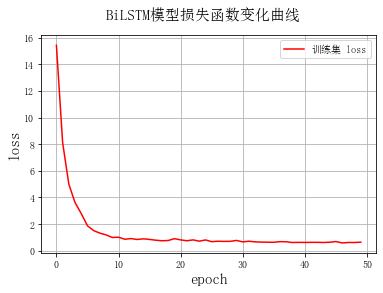

In [30]:
fig, ax = plt.subplots()#创建一个figure 
ax.plot(history.history['loss'], '-r', label='训练集 loss')

####打开网格
ax.grid(True)

####定义x, y轴的名称
ax.set_xlabel('epoch',fontsize=15)
ax.set_ylabel('loss',fontsize=15)

####定义标题
fig.suptitle('BiLSTM模型损失函数变化曲线',fontsize=15)

####展示图例 legend loc=是用来定义图例的位置的，还有很多选择，大家可以自己尝试
ax.legend(loc = 'upper right')

plt.savefig("BiLSTM模型损失函数变化曲线.png")

In [19]:
len(history.history['loss'])

50

In [20]:
history.history['loss']

[15.422783851623535,
 8.114373207092285,
 4.992214679718018,
 3.6122593879699707,
 2.788252353668213,
 1.8730120658874512,
 1.5130964517593384,
 1.3207587003707886,
 1.1901321411132812,
 0.9941277503967285,
 1.0170565843582153,
 0.8637735247612,
 0.9147672057151794,
 0.8466529250144958,
 0.8955297470092773,
 0.8498474359512329,
 0.7917774319648743,
 0.7498235106468201,
 0.7697475552558899,
 0.906852126121521,
 0.8163157105445862,
 0.7502200603485107,
 0.8154125809669495,
 0.7194541692733765,
 0.8109708428382874,
 0.6819730401039124,
 0.7137476801872253,
 0.701915979385376,
 0.7083989381790161,
 0.7732797265052795,
 0.6657428741455078,
 0.7174267768859863,
 0.6646221876144409,
 0.6512197852134705,
 0.6413149833679199,
 0.6365796327590942,
 0.684639036655426,
 0.6737300753593445,
 0.6194965243339539,
 0.6296554803848267,
 0.6244068741798401,
 0.6318758130073547,
 0.6316161751747131,
 0.6225709915161133,
 0.6380780935287476,
 0.6911188960075378,
 0.5883585810661316,
 0.6197815537452698,
 

In [21]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)

In [22]:
labels_t

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [23]:
res = model.predict([test,position1_t,position2_t,E_t])

In [24]:
res

array([[6.5190514e-05, 1.3229872e-02, 3.5317361e-01, 6.3337696e-01,
        1.5137500e-04, 2.9217779e-06],
       [4.7391137e-07, 8.6145855e-07, 1.7377008e-05, 1.1294054e-06,
        9.8268962e-01, 1.7290620e-02],
       [8.7337607e-01, 4.3131239e-04, 6.1676151e-06, 2.5506992e-07,
        3.5519106e-06, 1.2618268e-01],
       ...,
       [1.8306161e-01, 3.3416633e-05, 6.8336492e-05, 2.3122150e-06,
        7.3492447e-05, 8.1676078e-01],
       [8.6630490e-03, 2.4974424e-01, 3.3582377e-01, 3.6625591e-01,
        5.2899873e-04, 3.8984068e-02],
       [1.2384019e-05, 2.0860903e-11, 1.3159790e-04, 3.2112212e-12,
        2.8183268e-11, 9.9985600e-01]], dtype=float32)

In [25]:
result = []
for item in res:
    ls = list(item)
    idx = ls.index(max(ls))
    add_ls = [0]*6
    add_ls[idx] = 1
    result.append(add_ls)

In [26]:
result

[[0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0],
 [1, 0, 0, 0,

In [27]:
from sklearn.metrics import classification_report
print(classification_report(labels_t,result,digits = 4))

              precision    recall  f1-score   support

           0     0.8135    0.7649    0.7885       268
           1     0.7273    0.5882    0.6504        68
           2     0.5667    0.5152    0.5397        33
           3     0.5283    0.5600    0.5437        50
           4     0.7561    0.6200    0.6813        50
           5     0.7004    0.8219    0.7563       219

   micro avg     0.7282    0.7282    0.7282       688
   macro avg     0.6820    0.6450    0.6600       688
weighted avg     0.7322    0.7282    0.7271       688
 samples avg     0.7282    0.7282    0.7282       688



In [35]:
labels_t_list = []
for i in labels_t:
    res = list(i).index(1)
    labels_t_list.append(res)

In [36]:
result_list = []
for i in result:
    res = list(i).index(1)
    result_list.append(res)

In [37]:
len(labels_t_list) == len(result_list)

True

In [38]:
print(classification_report(labels_t_list,result_list,digits = 4))

              precision    recall  f1-score   support

           0     0.8135    0.7649    0.7885       268
           1     0.7273    0.5882    0.6504        68
           2     0.5667    0.5152    0.5397        33
           3     0.5283    0.5600    0.5437        50
           4     0.7561    0.6200    0.6813        50
           5     0.7004    0.8219    0.7563       219

    accuracy                         0.7282       688
   macro avg     0.6820    0.6450    0.6600       688
weighted avg     0.7322    0.7282    0.7271       688

